# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como objetivo la generación de clusters de usuarios a partir de el alquiler de ítems de la biblioteca Alfonso Borrero Cabal. Previamente se estrajeron los temas de cada ítem y en este notebook se generarán matrices dispersas que serán consumidad por el algoritmo de k-means para generar los clusters que posteriormente serán consumidos por los diferentes algoritmo de recomendación.

**Entrada**: Tabla_join.json

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>

# Importación de datos

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Estas son las librerias que vamos a usar para hacer el join de ambas tablas y poder hacer las diferentes agrupaciones de estudiantes. 

* pandas(pd): Permite almacenar los datos en dataframes(matrices) y operación entre las celdas.
* KMeans: librería de sklearn para realizar el algoritmo de agrupamiento Kmeans.
* StandartScaler: Permite estandarizar los datos en una escala predeterminada.
* silhoute_score: permite sacar la métrica de puntaje de silhoute para los algoritmos de clustering.
* Normalizer: Permite normalizar los datos
* PCA: principal component analisis permite la reducción de dimensionalidad de nuestros dataset, en busca de que los algoritmos se ejecuten a mayor velocidad.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

Importamos el archivo. Este proviene del join entre las tablas de material bibliográfico de la biblioteca y la información de prestamos de la biblioteca. 

In [2]:
df = pd.read_json('../../data/Join/JoinTablas.json')

In [3]:
df.head(3)

,RowID,Fecha,IDItem,NumeroUbicacion,Dewey,Ubicacion,Llave,Programa,Facultad,IDUsuario,Year,Signatura,TipoItem,Autor,Titulo,AnioPublicacion,DeweyEspecifico,TemaDewey,Temas,Union
0,Row0,1547050497000,80000005327627,720.98 A71S,720,COL-GRAL-2,866245,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,2019,720,LIBRO,"Arango Cardinal, Silvia 1948-",Ciudad y arquitectura seis generaciones que co...,2012.0,720.98,Arquitectura latinoamericana,"[arquitectur, histori, amer, latin]",arquitectur histori amer latin
1,Row1,1547050500000,80000001191496,720.9861 A71,720,COL-GRAL-2,309945,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,2019,720,LIBRO,"Arango Cardinal, Silvia 1948-",Historia de la arquitectura en Colombia Silvia...,1993.0,720.9861,Arquitectura colombiana,"[arquitectur, colonial, histori, colombi]",arquitectur colonial histori colombi
2,Row2,1547138763000,80000004979759,540 CH15Q 2010,540,COL-GRAL-3,822727,CARRERA DE ARQUITECTURA,arquitectura y diseño,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,2019,540,LIBRO,"Chang, Raymond",Química Raymond Chang ; revisión técnica Rosa ...,2010.0,540,Química,[quimic],quimic


Anotamos la estructura del archivo. 

In [4]:
print("Numero de filas:", df.shape[0])
print("Numero de columnas:", df.shape[1])

Numero de filas: 489474
Numero de columnas: 20


El clustering para este experimento se realizará sobre el atributo "Signatura" el cual representa el dewey hasta la unidad (dando aproximadamente 900 deweys diferentes). Recordar la diferencia entre la columna "Dewey" y "Signatura". La primera es la que originalmente contiene el dataset de prestamos y solo venía con valores hasta la decena, mientras que "Sginatura" originalmente era una valor que señalaba el dewey especifico del libro y su ubicación al interior de la biblioteca. Se realizo una transformación para obtener únicamente el valor númerico de este valor y así obtener el dewey hasta la unidad(más especifico).

In [5]:
eliminar = df.loc[df["Signatura"].isnull()]
print("Numero de datos sin Dewey(Singatura):" , eliminar.shape[0])

Numero de datos sin Dewey(Singatura): 0


In [6]:
print("Valores de signatura unicos: " , len(df["Signatura"].unique()))
print("Valores de Dewey(decena) unicos: " , len(df["Dewey"].unique()))

Valores de signatura unicos:  756
Valores de Dewey(decena) unicos:  99


A partir del análisis con expertos en negocio, se ha entendido que es importante tomar en cuenta el cambio de gustos de los usuarios a través del tiempo y dar menos peso a prestamos que se realizaron en el pasado a prestamos más recientes. Para esto se creará una nueva columna denominada "Peso" la cual determinará el peso quue tiene dicho prestamo.
La disminución del peso será exponencial según la diferencia con el año actual y se calculará con la siguiente formula:

$Peso = \frac{1}{2^{(2021-20xx)}}$


In [7]:
df["Peso"] = df.apply(lambda row: 1/2**(2021-row.Year), axis=1 )

In [8]:
df.columns

Index(['RowID', 'Fecha', 'IDItem', 'NumeroUbicacion', 'Dewey', 'Ubicacion',
       'Llave', 'Programa', 'Facultad', 'IDUsuario', 'Year', 'Signatura',
       'TipoItem', 'Autor', 'Titulo', 'AnioPublicacion', 'DeweyEspecifico',
       'TemaDewey', 'Temas', 'Union', 'Peso'],
      dtype='object')

Se creará una nueva tabla donde únicamente se van a tener en cuenta los deweys que le gustan a cada usuario así como los atributos para posteriormente realizar el clustering. 

In [11]:
pesos_usuarios = pd.DataFrame(columns= df["Signatura"].unique(),dtype=float)
tam = len(df["Signatura"].unique())
pesos_usuarios.columns = pesos_usuarios.columns.astype(str)
display(pesos_usuarios)

ids = df["IDUsuario"].unique()
i = 0
for usuario in ids:
  pesos_usuarios.loc[i] = np.zeros((tam,), dtype=int)
  #Para cada usuario traer sus Deweys y sus pesas asociados
  prestamos = df.loc[df["IDUsuario"]==usuario]
  deweys = prestamos[["Signatura","Peso"]]
  result_user = deweys.groupby("Signatura")["Peso"].sum().reset_index(name="Peso")
  # Recorrer los Deweys y Pesos para plasmarlos en una matriz
  #display(result_user)
  for index, row in result_user.iterrows():
    d = row["Signatura"]
    p=row['Peso']
    pesos_usuarios[d][i] = p
  i = i+1

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586


La matriz generada es una matriz dispersa donde todos los valores son ceros excepto donde el usuario haya realizado un prestamo.

In [12]:
pesos_usuarios.shape

(24407, 756)

# Configuración Modelos
A partir del archivo "Comparación modelos" se puede concluir que el modelo que ayuda en mayor medida a agrupar los datos, minimizando el número de clusters con tamaño menor a 20 y la desviación estandar es kmeans con los siguiente parámetros:
* Filas normalizadas = true
* Columnas normalizadas = true
* PCA = 0.95
* Número de clusters = 150
* Número de iteraciones = 500

In [13]:
resumen = pd.DataFrame(columns = ["Tecnica","PCA", "Norm_filas", "Norm_col", "Precision", "Desviacion_estandar", "Media", "Coeficiente_variacion", "Clusters","Grupo_mas_grande", "Grupos<10", "Grupos<20"])


In [14]:
def std_dev_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.std(sizes_labels)

In [18]:
def mean_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.mean(sizes_labels)

In [20]:
#
PCA = 0.95
num_clusters = 150
num_iter = 30

# Algoritmo kmeans

In [21]:
final = pesos_usuarios

In [22]:
##Exportamos los datos del modelo que nos dio mejores resultados
#Normalización
#2.5 min por iteración
sumatoria = final.sum(axis=1)
pesos_norm = final.div(sumatoria, axis=0).fillna(0)

scaler = MinMaxScaler()
pesos_norm = scaler.fit_transform(pesos_norm.values)

  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_norm)
labels = k_means.labels_

In [23]:
#Desempeño
#3 min
pres = silhouette_score(pesos_norm, labels)
print("silhouette_score: ", pres)

silhouette_score:  0.27459456939317484


In [26]:
grouped = df.groupby("IDUsuario")["Peso"].sum().reset_index(name="Peso")
grouped

,IDUsuario,Peso
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.500
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.500
2,000a0630c32a437052696f6921e3181f155291d0,0.500
3,000c040064aedd76057c5309064a3823db970644,0.125
4,000f23e62e6d4995ede7090c6447ad6736edc4de,1.500
...,...,...
24402,fff71390a9f54ced5134452870d70ff18812f05f,2.125
24403,fff716c9685b5267e6ecfcdc00e9303509355bc1,1.000
24404,fff735f54719b720fc4c6c723208ad1f06e9605e,14.500
24405,fffb2be68fef4b27a810b11a641d84052eb02347,0.500


<AxesSubplot:>

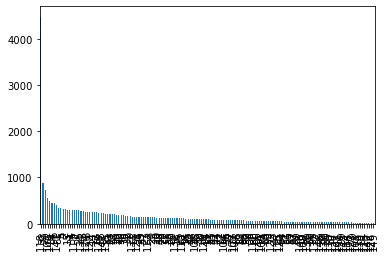

In [27]:
#copiamos el dataframe y agregamos los clusters para gráficar la distribución
df2 = final.copy()
df2["cluster"] = labels
df2.groupby("cluster")["cluster"].count()
display(df2["cluster"].value_counts().plot(kind='bar'))

#pegamos los cluster a la tabla que tiene los usuarios y los temas
grouped["cluster"] = labels


#Cálculo de métricas
media = mean_cluster(df2,labels)
desviacion = std_dev_cluster(df2,labels)
data = df2.groupby('cluster')['cluster'].count()
peque10 = len(data[data<=10])
peque20 = len(data[data<=20])
masGrande = data.max()
#Agregamos los datos a nuestra tabla de resumen para comparar
resumen = resumen.append({'Tecnica':"K-MEANS",
                              'PCA':0.95,
                              'Norm_filas':True,
                              'Norm_col':True,
                              'Precision':pres,
                              'Desviacion_estandar':desviacion,
                              'Media':media,
                              'Coeficiente_variacion':desviacion/media, 
                              'Clusters': num_clusters,
                              "Grupos<20":peque20,
                              "Grupos<10":peque10 , 
                              "Grupo_mas_grande":masGrande}, ignore_index=True)

In [28]:
grouped.head(3)

,IDUsuario,Peso,cluster
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.5,125
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.5,118
2,000a0630c32a437052696f6921e3181f155291d0,0.5,118


In [29]:
resumen

,Tecnica,PCA,Norm_filas,Norm_col,Precision,Desviacion_estandar,Media,Coeficiente_variacion,Clusters,Grupo_mas_grande,Grupos<10,Grupos<20
0,K-MEANS,0.95,True,True,0.274595,377.056465,162.713333,2.317305,150,4479,0,4


Podemos analizar los temas más importantes que tiene cada cluster. 

In [95]:
cluster = df2.loc[df2.cluster == 33]
aux=cluster.astype(bool).sum(axis=0)
df3 = aux[aux > 0]
df3.sort_values(ascending=False).head(20)

cluster    200
574        200
616          7
576          4
611          3
575          3
540          3
333          2
613          2
610          2
612          2
581          2
530          2
R            2
614          1
808          1
725          1
303          1
592          1
843          1
dtype: int64

In [35]:
grouped.head(3)

,IDUsuario,Peso,cluster
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.5,125
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.5,118
2,000a0630c32a437052696f6921e3181f155291d0,0.5,118


Pegamos la información del cluster a cada uno de los prestamos de los usuarios.(temas_usuarios_cluster)

In [36]:
material_data = pd.DataFrame(data=df)
cluster_data = pd.DataFrame(data=grouped)
temas_usuarios_cluster = pd.merge(material_data, cluster_data, left_on='IDUsuario', right_on='IDUsuario', how='left')
temas_usuarios_cluster.head(3)

,RowID,Fecha,IDItem,NumeroUbicacion,Dewey,Ubicacion,Llave,Programa,Facultad,IDUsuario,...,Autor,Titulo,AnioPublicacion,DeweyEspecifico,TemaDewey,Temas,Union,Peso_x,Peso_y,cluster
0,Row0,1547050497000,80000005327627,720.98 A71S,720,COL-GRAL-2,866245,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,...,"Arango Cardinal, Silvia 1948-",Ciudad y arquitectura seis generaciones que co...,2012.0,720.98,Arquitectura latinoamericana,"[arquitectur, histori, amer, latin]",arquitectur histori amer latin,0.25,5.25,15
1,Row1,1547050500000,80000001191496,720.9861 A71,720,COL-GRAL-2,309945,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,...,"Arango Cardinal, Silvia 1948-",Historia de la arquitectura en Colombia Silvia...,1993.0,720.9861,Arquitectura colombiana,"[arquitectur, colonial, histori, colombi]",arquitectur colonial histori colombi,0.25,5.25,15
2,Row2,1547138763000,80000004979759,540 CH15Q 2010,540,COL-GRAL-3,822727,CARRERA DE ARQUITECTURA,arquitectura y diseño,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,...,"Chang, Raymond",Química Raymond Chang ; revisión técnica Rosa ...,2010.0,540,Química,[quimic],quimic,0.25,5.50,118


Crearemos un tercer dataframe el cual contega únicamente la información de cada cluster(sus centroides). 

In [44]:
centroids = pd.DataFrame(data = k_means.cluster_centers_)

In [56]:
centroids.columns = df["Signatura"].unique()
centroids

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586
0,0.891100,0.000000,0.000000,0.006855,0.000758,0.000000,0.000631,0.000000,0.000140,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007524,0.000019,0.001273,0.001755,0.325837,0.002025,0.016767,0.006725,0.033209,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001903,0.000000,0.001907,0.000000,0.007182,0.000442,0.002778,0.023522,0.009621,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.002262,0.000952,0.000000,0.000000,0.863419,0.000000,0.005357,0.000794,0.003828,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000994,0.000236,0.005798,0.000250,0.005909,0.002447,0.006718,0.108800,0.017449,0.000099,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.004084,0.000423,0.006029,0.000402,0.007969,0.001233,0.008632,0.016815,0.020695,0.000451,...,0.0,0.0,0.0,0.00202,0.0,0.0,0.0,0.0,0.0,0.0
146,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.000000,0.009656,0.001989,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
147,0.005995,0.000437,0.000000,0.001390,0.003390,0.000688,0.004602,0.010897,0.017072,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
148,0.000000,0.000000,0.000153,0.000000,0.017500,0.000000,0.000000,0.002273,0.001344,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
centroids[centroids<1e-5] = 0

Finalmente exportamos las tablas para ser consumidas por los sistemas de recomedación junto al dashboard.
* Grouped_temas = usuarios + cluster
* temas_usuarios_cluster = joinTablas + cluster
* Centroids_deweys = clusters + centroides

In [42]:
grouped.to_json('../../data/GruposDeweyUnidad/userCluster.json')

In [43]:
temas_usuarios_cluster.to_json('../../data/GruposDeweyUnidad/joinCluster.json')

In [57]:
centroids.to_json('../../data/GruposDeweyUnidad/centroids.json')